In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from plot_setting import set_plot_style
set_plot_style()

Smoothing functions

In [ ]:
def first_order_mc_grad(x, grad_g, eps=0.1, M=100, distribution="normal", seed=0):
    #np.random.seed(seed)
    x = np.atleast_1d(x)  # (n)
    if distribution=="normal":
        Z = np.random.randn(M, x.shape[-1])  # draw samples (M, n)
    # print(f"shape(Z) = {Z.shape}")
    grads = grad_g(x + eps * Z)  # compute gradients at perturbed points (M, n)
    # print(f"shape(grads) = {grads.shape}")
    grad_est = np.mean(grads, axis=0)  # average
    # print(f"shape(grad_est) = {grad_est.shape}")
    return grad_est

def zero_order_mc_grad(x, g, eps=0.1, M=100, distribution="normal", seed=0):
    #np.random.seed(seed)
    # Different sampling distribution
    x = np.atleast_1d(x)  # (n,)
    if distribution=="normal":
        Z = np.random.randn(M, x.shape[-1])  # draw samples (M, n)
        S = -Z
    
    # print(f"shape(Z) = {Z.shape}")
    g_x = g(x)  # (1,)
    # print(f"shape(g_x) = {g_x.shape}")
    g_x_eps = g(x + eps * Z)  # (M, 1)
    # print(f"shape(g_x_eps) = {g_x_eps.shape}")
    # Average over samples
    grad_est = np.mean((g_x - g_x_eps) * S / eps, axis=0)  # (n,)
    return grad_est

def interp_mc_grad(x, g, grad_g, alpha=0.5, eps=0.1, M=100, distribution="normal"):
    x = np.atleast_1d(x)  # (n,)
    if distribution=="normal":
        Z = np.random.randn(M, x.shape[-1])  # draw samples (M, n)
        S = -Z
    
    g_pert = g(x + eps * Z)
    grads_pert = grad_g(x + eps * Z)

    grad_est_fo = np.mean(grads_pert, axis=0)
    grad_est_zo = np.mean((g(x) - g_pert) * S / eps, axis=0)

    grad_est_interp = alpha*grad_est_fo + (1-alpha) * grad_est_zo

    return grad_est_interp


def interp_mc_grad_adaptive(x, g, grad_g, eps=0.1, M=100, distribution="normal", gamma=1.0):
    x = np.atleast_1d(x)
    n = x.shape[-1]

    # Sample perturbations
    if distribution == "normal":
        Z0 = np.random.randn(M, n)
        Z1 = np.random.randn(M, n)
        S0 = -Z0

    # Evaluate perturbed samples
    g_x = g(x)
    g_pert = g(x + eps * Z0)
    grads_pert = grad_g(x + eps * Z1)

    # Compute estimators
    grad_est_fo_samples = grads_pert
    grad_est_zo_samples = (g_x - g_pert) * S0 / eps

    grad_est_fo = grad_est_fo_samples.mean(axis=0)
    grad_est_zo = grad_est_zo_samples.mean(axis=0)

    # Empirical variances
    var_fo = np.mean(np.sum((grad_est_fo_samples - grad_est_fo)**2, axis=1))
    var_zo = np.mean(np.sum((grad_est_zo_samples - grad_est_zo)**2, axis=1))

    # Robustness constraint quantities
    B = np.linalg.norm(grad_est_fo - grad_est_zo)
    eps_conf = np.sqrt(var_zo / M)   # rough confidence proxy

    # Adaptive alpha selection (Eq. 5)
    alpha_inf = var_zo / (var_zo + var_fo + 1e-12)
    if alpha_inf * B <= gamma - eps_conf:
        alpha = alpha_inf
    else:
        alpha = max(0.0, min(1.0, (gamma - eps_conf) / (B + 1e-12)))

    # Interpolated gradient
    grad_est_interp = alpha * grad_est_fo + (1 - alpha) * grad_est_zo

    return grad_est_interp, alpha


def mppi_grad(x, g, eps=0.1, lam=0.1, M=100, Sigma=None, seed=0):
    # np.random.seed(seed)
    x = np.atleast_1d(x)
    n = x.shape[-1]
    if Sigma is None:
        Sigma_inv = np.eye(n)  # (n, n)
    else:
        Sigma_inv = np.linalg.inv(Sigma)

    Z = np.random.randn(M, n)  # (M, n)
    g_x_eps = g(x + eps * Z)  # (M, 1)
    log_exp = np.exp(-g_x_eps / lam)  # (M, 1)

    num = np.sum(log_exp * (Z @ Sigma_inv.T), axis=0)
    grad_est = (-lam / eps) * num / np.sum(log_exp)
    return grad_est


def g_smoothed(x, g, eps=0.1, M=100, seed=0):    
    #np.random.seed(seed)
    x = np.atleast_1d(x)
    Z = np.random.randn(M, x.shape[0])  # draw samples
    g_x_eps = g(x + eps * Z)
    return np.mean(g_x_eps, axis=0)

def g_mppi_smoothed(x, g, eps=0.1, lam=1.0, M=100, seed=0):
    # np.random.seed(seed)
    x = np.atleast_1d(x)
    Z = np.random.randn(M, x.shape[-1])
    g_x_eps = g(x + eps * Z)
    log_exp = np.exp(-g_x_eps / lam)
    g_smoothed = -lam * np.log(np.mean(log_exp))
    return g_smoothed


# TODO: check
def g_bundle_smoothed(x, g, bundle_points, eps=0.1):
    """
    Args:
        x: point at which to evaluate the smoothed function (n,)
        g: original function handle
        bundle_points: array of shape (m, n) containing m bundle centers
        eps: controls neighborhood scaling (optional)
    """
    x = np.atleast_1d(x)
    W_y = np.asarray(bundle_points)  # (m, n)
    W_p = np.array([g(y) for y in W_y])  # (m, 1)

    # Compute interpolation weights α based on distance from x
    # Softmax-like normalized weighting
    dists = np.linalg.norm((W_y - x) / eps, axis=1)
    weights = np.exp(-dists**2)
    alpha = weights / np.sum(weights)  # (m,)

    # Linear interpolation of function outputs
    g_hat = np.dot(W_p.T, alpha)  # scalar or vector depending on g
    return g_hat

Examples

In [3]:
# Examples

# ----------------------
# g1 -- smooth 1D with multiple minima
# g1(x) = x^2 + 0.1 sin(20x)
def g1(x):
    x = np.atleast_1d(x)
    assert x.shape[-1] == 1, "x.shape[-1] must be 1"
    return x**2 + 0.1 * np.sin(20*x)

def grad_g1(x):
    """g1'(x) = 2x + 2cos(20x)"""
    x = np.atleast_1d(x)
    assert x.shape[-1] == 1, "x.shape[-1] must be 1"
    return 2*x + 2 * np.cos(20*x)


# ----------------------
# g2 -- Heaviside (step) function
# g2(x) = 0 if x < 0, else 1
def g2(x):
    x = np.atleast_1d(x)
    assert x.shape[-1] == 1, "x.shape[-1] must be 1"
    return (x >= 0).astype(float)

def grad_g2(x):
    """Derivative of Heaviside: 0 everywhere except undefined at 0.
    For practical purposes, return 0 array."""
    x = np.atleast_1d(x)
    assert x.shape[-1] == 1, "x.shape[-1] must be 1"
    return np.zeros_like(x)


# ----------------------
# g3 -- ReLU
# g3(x) = max(0, x)
def g3(x):
    x = np.atleast_1d(x)
    assert x.shape[-1] == 1, "x.shape[-1] must be 1"
    return np.maximum(0, x)

def grad_g3(x):
    """Derivative of ReLU: 1 if x > 0, 0 if x < 0, undefined at 0.
    We define grad(0) = 0 for simplicity."""
    x = np.atleast_1d(x)
    assert x.shape[-1] == 1, "x.shape[-1] must be 1"
    grad = np.zeros_like(x)
    grad[x > 0] = 1.0
    return grad


Plotting

In [4]:
def plot_smoothed_function(g_func, g_smoothed, x_values, eps_values, M_values):
    np.random.seed(0)
    g = [g_func(x) for x in x_values]
    cmap = sns.color_palette("viridis", as_cmap=True)
    norm = LogNorm(min(eps_values), max(eps_values))
    print("Smoothed function")
    fig, axs = plt.subplots(1, len(M_values), figsize=(2.5 * len(M_values), 3), sharey=False)
    for ax, M in zip(axs, M_values):
        ax.plot(x_values, g, "k", label="original", alpha=0.8)
        for eps in eps_values:
            color = cmap(norm(eps))
            g_rs = np.array([g_smoothed(x, g_func, eps=eps, M=M) for x in x_values])
            ax.plot(x_values, g_rs, label=f"RS ε={eps}", color=color, alpha=0.8)
            ax.set_title(f"M={M}")
    ax.legend()
    plt.show()


def plot_grad_estimation(func_or_grad, grad_estimator,  x_values, eps_values, M_values, grad_true=None):
    np.random.seed(0)
    if grad_true:
        grad = [grad_true(x) for x in x_values]
    cmap = sns.color_palette("viridis", as_cmap=True)
    norm = LogNorm(min(eps_values), max(eps_values))
    # print("Zero order")
    fig, axs = plt.subplots(1, len(M_values), figsize=(2.5 * len(M_values), 3), sharey=False)
    for ax, M in zip(axs, M_values):
        if grad_true:
            ax.plot(x_values, grad, "k", label="original")
        for eps in eps_values:
            color = cmap(norm(eps))
            grad_rs_zo = np.array([grad_estimator(x, func_or_grad, eps=eps, M=M) for x in x_values])
            ax.plot(x_values, grad_rs_zo, label=f"RS ε={eps}", color=color, alpha=0.8)
            ax.set_title(f"M={M}")
    ax.legend()
    plt.show()

def plot_comparison_grad(
    g_func, grad_func,
    zero_order_mc_grad, first_order_mc_grad,
    x_values, eps_values, M,
    mppi_grad_func=None, lam_mppi=0.1,
    adaptive_grad_func=None
):
    np.random.seed(0)
    grad = [grad_func(x) for x in x_values]
    print(f"M = {M}")
    
    fig, axs = plt.subplots(1, len(eps_values), figsize=(2.5 * len(eps_values), 3), sharey=False)
    axs = np.atleast_1d(axs)


    for ax, eps in zip(axs, eps_values):
        grad_rs_zo = np.array([zero_order_mc_grad(x, g_func, eps=eps, M=M) for x in x_values])
        grad_rs_fo = np.array([first_order_mc_grad(x, grad_func, eps=eps, M=M) for x in x_values])

        ax.plot(x_values, grad, "k", alpha=0.8, label="True")
        ax.plot(x_values, grad_rs_zo, alpha=0.8, label="ZO")
        ax.plot(x_values, grad_rs_fo, alpha=0.8, label="FO")

        if mppi_grad_func is not None:
            grad_mppi = np.array([
                mppi_grad_func(x, g_func, eps=eps, lam=lam_mppi, M=M)
                for x in x_values
            ])
            ax.plot(x_values, grad_mppi, alpha=0.8, label="MPPI")

    
        if adaptive_grad_func is not None:
            results = [
                adaptive_grad_func(x, g_func, grad_func, eps=eps, M=M)
                for x in x_values
            ]
            # If function returns (grad, alpha), extract grad only
            if isinstance(results[0], (list, tuple)):
                grads_adapt = np.array([r[0] for r in results])
            else:
                grads_adapt = np.array(results)
            ax.plot(x_values, grads_adapt, alpha=0.8, label="Adaptive")
            
        ax.set_title(f"ε = {eps}")
        ax.set_xlabel("x")

    axs[-1].legend()
    plt.tight_layout()
    plt.show()

    
def plot_grad_estimation_interpolated(
    g, grad_g, grad_estimator, x_values, eps_values, M_values,
    grad_true=None, alpha_values=[0.2, 0.5, 0.8]
):
    np.random.seed(0)
    cmap = sns.color_palette("viridis", as_cmap=True)
    norm = LogNorm(min(eps_values), max(eps_values))

    print("Interpolated gradient estimation")
    fig, axs = plt.subplots(1, len(M_values), figsize=(2.5 * len(M_values), 3), sharey=False)

    for ax, M in zip(axs, M_values):
        if grad_true is not None:
            grad_vals = np.array([grad_true(x) for x in x_values])
            ax.plot(x_values, grad_vals, "k", lw=2, label="True g'(x)")

        for alpha in alpha_values:
            for eps in eps_values:
                color = cmap(norm(eps))
                grad_est = np.array([
                    grad_estimator(x, g, grad_g, alpha=alpha, eps=eps, M=M)
                    for x in x_values
                ])
                label = f"alpha={alpha}, eps={eps}"
                ax.plot(x_values, grad_est, label=label, color=color, alpha=0.8)

        ax.set_title(f"M={M}")
        ax.set_xlabel("x")

    ax.legend()
    plt.tight_layout()
    plt.show()


def plot_grad_estimation_adaptive(
    g, grad_g, grad_estimator, x_values, eps_values, M_values,
    grad_true=None, show_alpha=False
):
    np.random.seed(0)
    cmap = sns.color_palette("viridis", as_cmap=True)
    norm = LogNorm(min(eps_values), max(eps_values))

    title = "Adaptive alpha" if show_alpha else "Adaptive gradient estimation"
    print(title)
    fig, axs = plt.subplots(1, len(M_values), figsize=(2.5 * len(M_values), 3), sharey=False)
    axs = np.atleast_1d(axs)

    for ax, M in zip(axs, M_values):
        if grad_true is not None and not show_alpha:
            grad_vals = np.array([grad_true(x) for x in x_values])
            ax.plot(x_values, grad_vals, "k", lw=2, label="True g'(x)")

        for eps in eps_values:
            color = cmap(norm(eps))
            results = [grad_estimator(x, g, grad_g, eps=eps, M=M) for x in x_values]
            grads = np.array([r[0] for r in results])
            alphas = np.array([r[1] for r in results])

            if show_alpha:
                ax.plot(x_values, alphas, label=f"ε={eps}", color=color, alpha=0.8)
            else:
                ax.plot(x_values, grads, label=f"ε={eps}", color=color, alpha=0.8)

        ax.set_title(f"M={M}")
        ax.set_xlabel("x")

    axs[-1].legend()
    plt.tight_layout()
    plt.show()


Bundled Trajectory

In [5]:
# bundle_points = np.linspace(-2, 2, 5).reshape(-1, 1)
# x_values = np.linspace(-2, 2, 200)
# y_true = [g1([x]) for x in x_values]
# y_bundle = [g_bundle_smoothed(np.array([x]), g1, bundle_points) for x in x_values]

# plt.plot(x_values, y_true, "k", label="g1")
# plt.plot(x_values, y_bundle, label="Bundle smoothed")
# plt.legend()
# plt.show()


Smoothed function


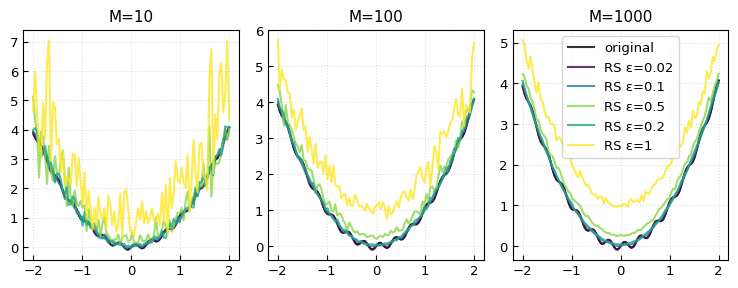

Zero order MC


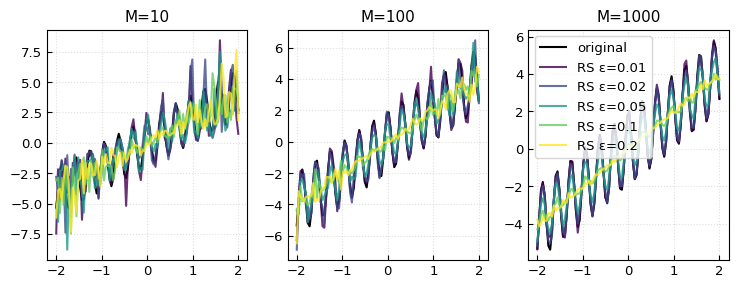

First order MC


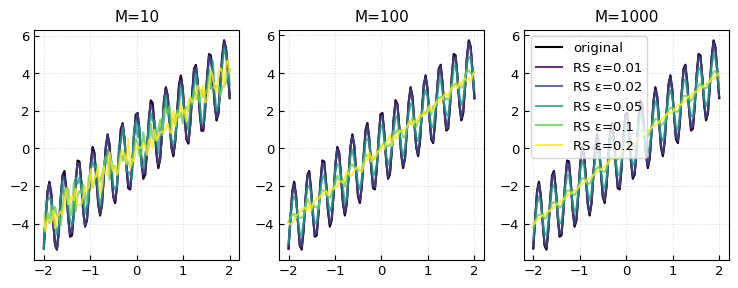

MPPI
Smoothed function


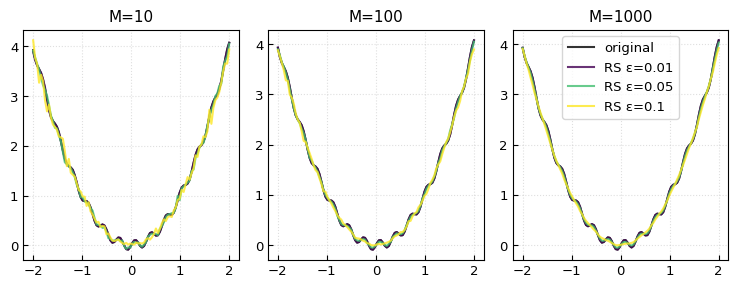

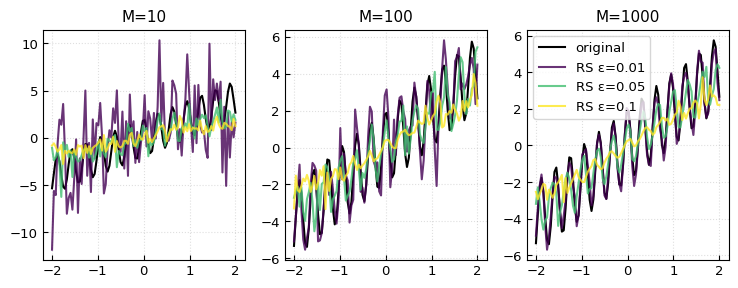

Adaptive gradient estimation


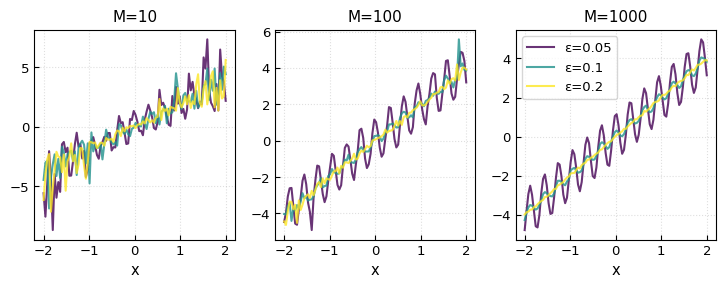

Adaptive alpha


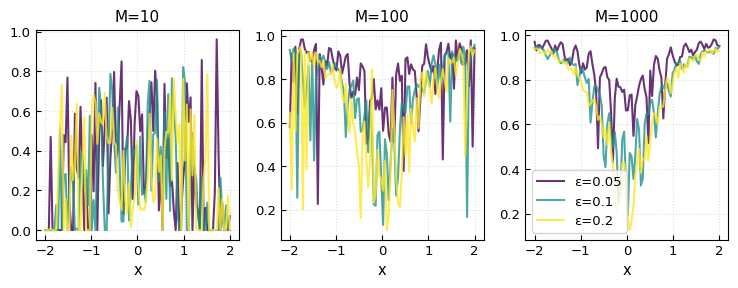

M = 100


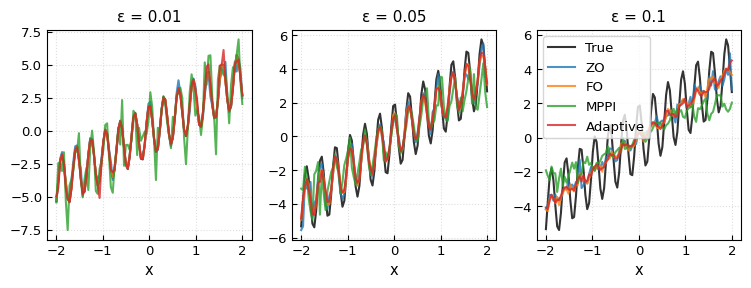

In [6]:
x_values = np.linspace(-2, 2, 100)
M_values = [10, 100, 1000]

plot_smoothed_function(g1, g_smoothed, x_values, eps_values=[0.02, 0.1, 0.5, 0.2, 1], M_values=M_values)
print("Zero order MC")
plot_grad_estimation(g1, zero_order_mc_grad, x_values, eps_values=[0.01, 0.02, 0.05, 0.1, 0.2],  M_values=M_values, grad_true=grad_g1)
print("First order MC")
plot_grad_estimation(grad_g1, first_order_mc_grad, x_values, eps_values=[0.01, 0.02, 0.05, 0.1, 0.2],  M_values=M_values, grad_true=grad_g1)
print("MPPI")
eps_values = [0.01, 0.05, 0.1]
plot_smoothed_function(g1, g_mppi_smoothed, x_values, eps_values, M_values)
plot_grad_estimation(g1, mppi_grad, x_values, eps_values, M_values, grad_true=grad_g1)

plot_grad_estimation_adaptive(g=g1,grad_g=grad_g1,grad_estimator=interp_mc_grad_adaptive, 
                              x_values=x_values,eps_values=[0.05, 0.1, 0.2],M_values=M_values,grad_true=None)

plot_grad_estimation_adaptive(g=g1, grad_g=grad_g1, grad_estimator=interp_mc_grad_adaptive, x_values=x_values,
                             eps_values=[0.05, 0.1, 0.2], M_values=M_values, show_alpha=True)

plot_comparison_grad(g1, grad_g1, zero_order_mc_grad, first_order_mc_grad, x_values, 
                     eps_values=[0.01, 0.05, 0.1], M=100, mppi_grad_func=mppi_grad, adaptive_grad_func=interp_mc_grad_adaptive)



Smoothed function


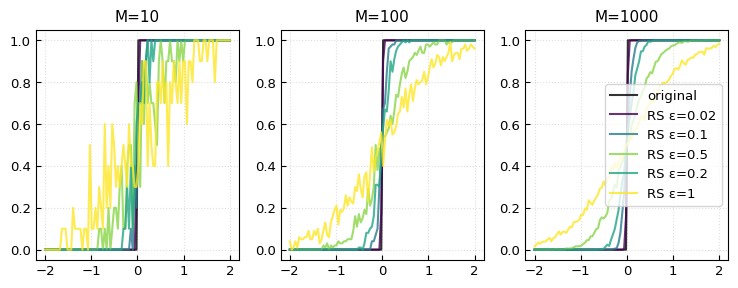

Zero order MC


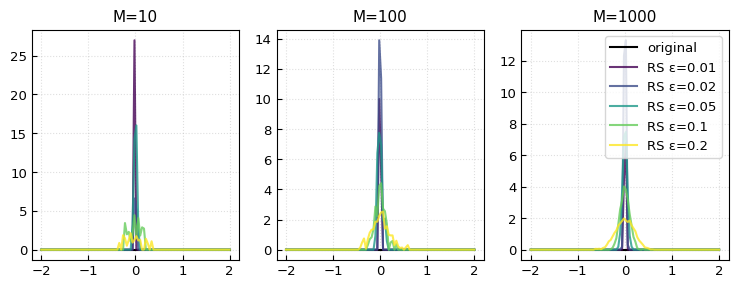

First order MC


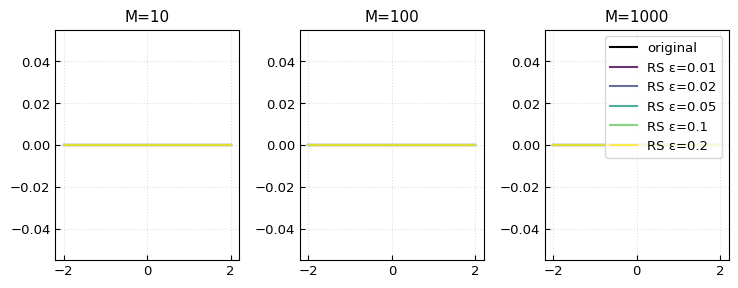

MPPI
Smoothed function


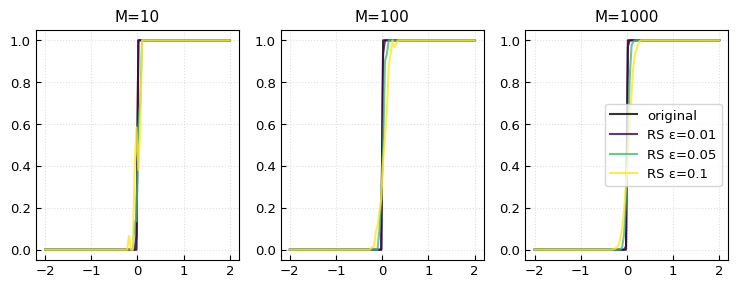

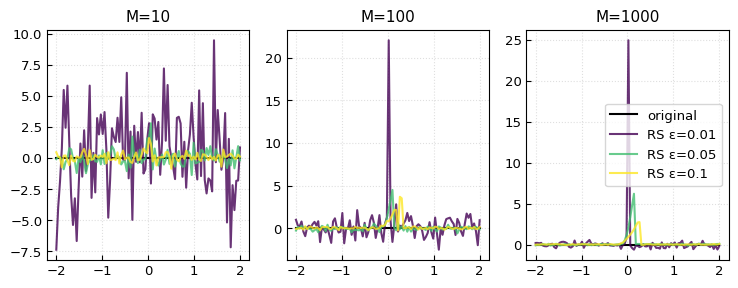

Adaptive gradient estimation


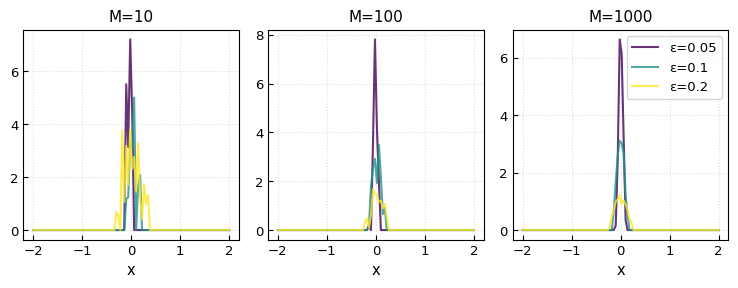

Adaptive alpha


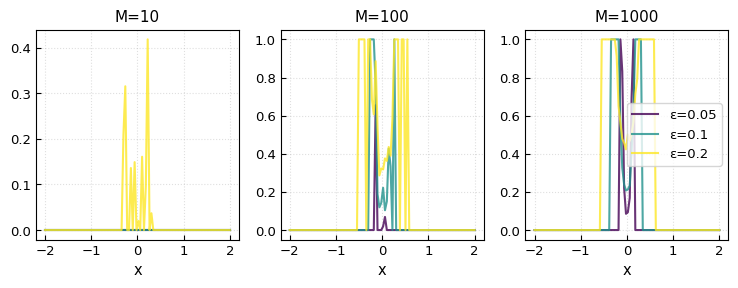

M = 100


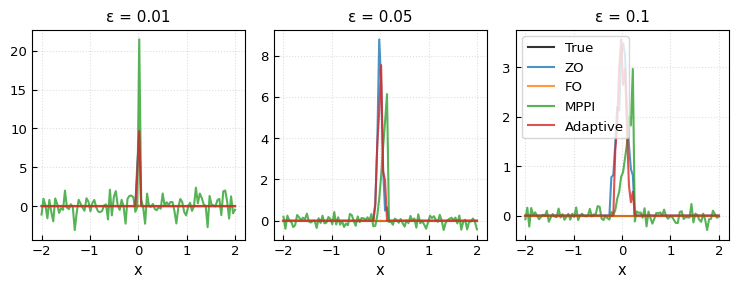

In [7]:
x_values = np.linspace(-2, 2, 100)
M_values = [10, 100, 1000]

# ---- g2 ----
plot_smoothed_function(g2, g_smoothed, x_values, eps_values=[0.02, 0.1, 0.5, 0.2, 1], M_values=M_values)
print("Zero order MC")
plot_grad_estimation(g2, zero_order_mc_grad, x_values, eps_values=[0.01, 0.02, 0.05, 0.1, 0.2], M_values=M_values, grad_true=grad_g2)
print("First order MC")
plot_grad_estimation(grad_g2, first_order_mc_grad, x_values, eps_values=[0.01, 0.02, 0.05, 0.1, 0.2], M_values=M_values, grad_true=grad_g2)
print("MPPI")
eps_values = [0.01, 0.05, 0.1]
plot_smoothed_function(g2, g_mppi_smoothed, x_values, eps_values, M_values)
plot_grad_estimation(g2, mppi_grad, x_values, eps_values, M_values, grad_true=grad_g2)


plot_grad_estimation_adaptive(g=g2,grad_g=grad_g2,grad_estimator=interp_mc_grad_adaptive, 
                              x_values=x_values,eps_values=[0.05, 0.1, 0.2],M_values=M_values,grad_true=None)

plot_grad_estimation_adaptive(g=g2, grad_g=grad_g2, grad_estimator=interp_mc_grad_adaptive, x_values=x_values,
                             eps_values=[0.05, 0.1, 0.2], M_values=M_values, show_alpha=True)

plot_comparison_grad(g2, grad_g2, zero_order_mc_grad, first_order_mc_grad, x_values, 
                     eps_values=[0.01, 0.05, 0.1], M=100, mppi_grad_func=mppi_grad, adaptive_grad_func=interp_mc_grad_adaptive)


Smoothed function


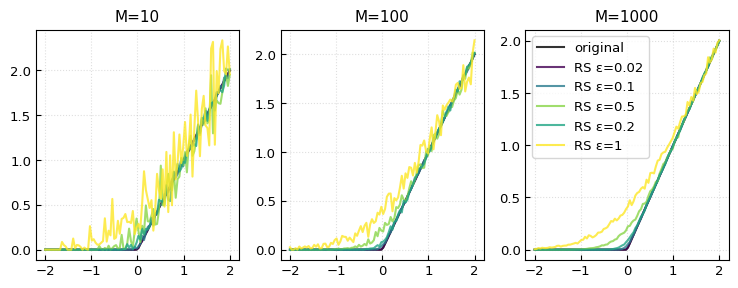

Zero order MC


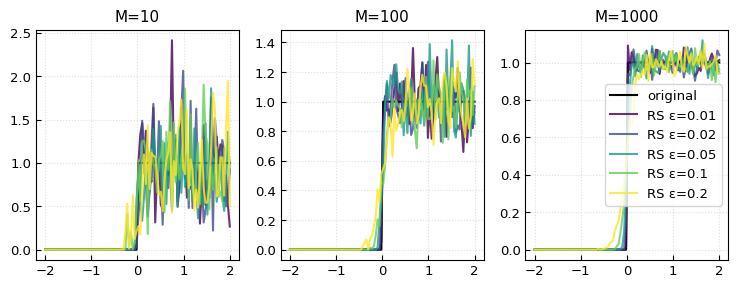

First order MC


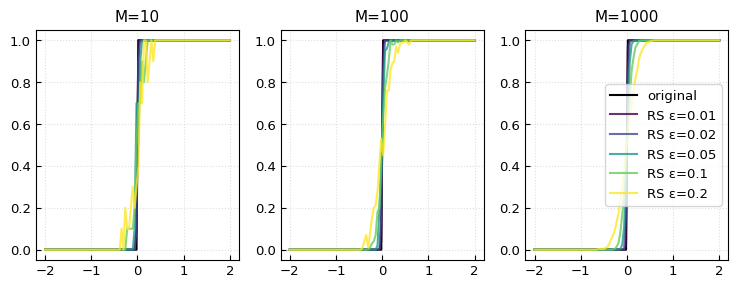

MPPI
Smoothed function


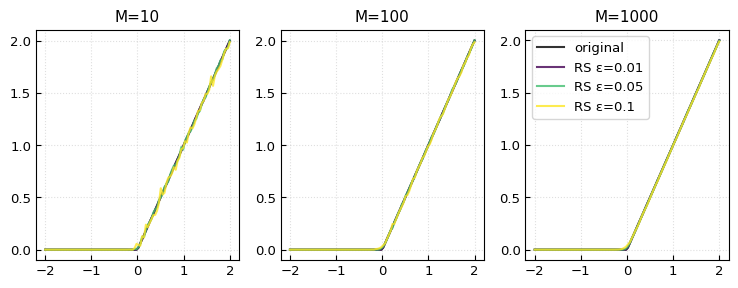

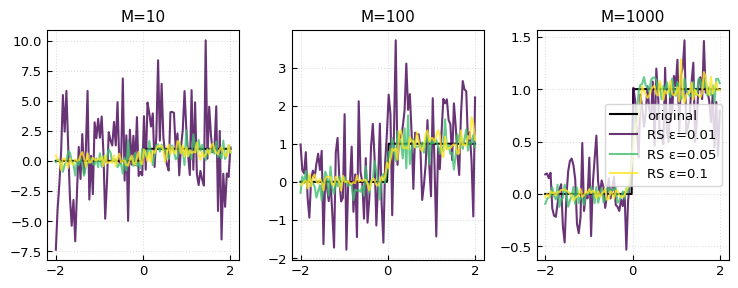

Adaptive gradient estimation


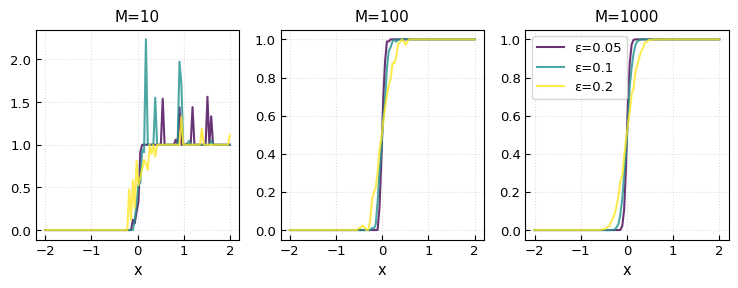

Adaptive alpha


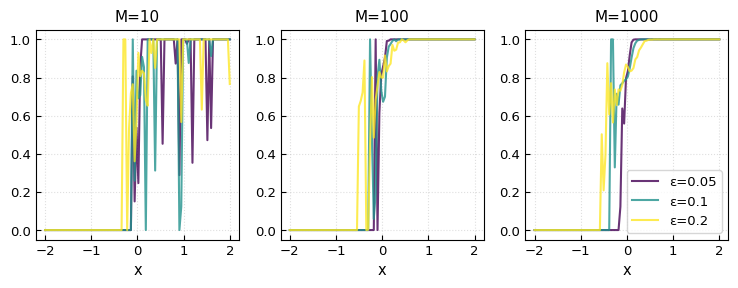

M = 100


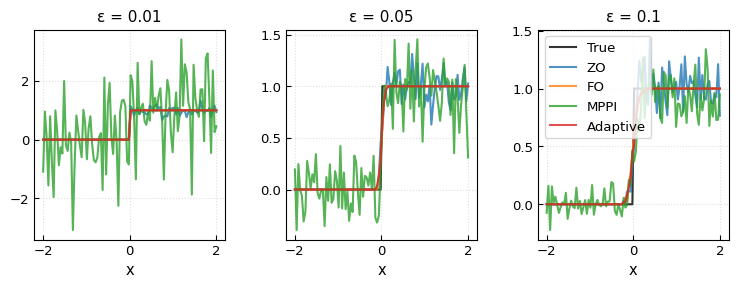

In [8]:
x_values = np.linspace(-2, 2, 100)
M_values = [10, 100, 1000]
# ---- g3 ----
plot_smoothed_function(g3, g_smoothed, x_values, eps_values=[0.02, 0.1, 0.5, 0.2, 1], M_values=M_values)
print("Zero order MC")
plot_grad_estimation(g3, zero_order_mc_grad, x_values, eps_values=[0.01, 0.02, 0.05, 0.1, 0.2], M_values=M_values, grad_true=grad_g3)
print("First order MC")
plot_grad_estimation(grad_g3, first_order_mc_grad, x_values, eps_values=[0.01, 0.02, 0.05, 0.1, 0.2], M_values=M_values, grad_true=grad_g3)
print("MPPI")
eps_values = [0.01, 0.05, 0.1]
plot_smoothed_function(g3, g_mppi_smoothed, x_values, eps_values, M_values)
plot_grad_estimation(g3, mppi_grad, x_values, eps_values, M_values, grad_true=grad_g3)


plot_grad_estimation_adaptive(g=g3,grad_g=grad_g3,grad_estimator=interp_mc_grad_adaptive, 
                              x_values=x_values,eps_values=[0.05, 0.1, 0.2],M_values=M_values,grad_true=None)

plot_grad_estimation_adaptive(g=g3, grad_g=grad_g3, grad_estimator=interp_mc_grad_adaptive, x_values=x_values,
                             eps_values=[0.05, 0.1, 0.2], M_values=M_values, show_alpha=True)

plot_comparison_grad(g3, grad_g3, zero_order_mc_grad, first_order_mc_grad, x_values, 
                     eps_values=[0.01, 0.05, 0.1], M=100, mppi_grad_func=mppi_grad, adaptive_grad_func=interp_mc_grad_adaptive)
